# Experiment transforms
Somehow similar to the filters API, the transforms are objects that aim to "transform" the experiment object to a new experiment object.

Again, the returned value should always be a new Experiment object, this allows chaining and pipelining of transforms aka "the Fluent interface".

Similar to how filters are applied using the *filter* methods, the transform API is applied using the **apply** method.

Examples of transforms are listed in this notebook/chapter.

In [1]:
%load_ext autoreload
%autoreload 2

#Load our data
from omicexperiment.experiment.microbiome import MicrobiomeExperiment

mapping = "example_map.tsv"
biom = "example_fungal.biom"
tax = "blast_tax_assignments.txt"

exp = MicrobiomeExperiment(biom, mapping,tax)

In [2]:
exp.data_df

,1234,9876,sample0,sample1,sample2
2f328e48f4252bbade0dd7f66b0d5bf1b09617dd,0,225872,0,2,0
ae0ddda08027454fdb5db77c96b94691b8274cdd,2,1,0,91911,100428
8f52abc02aed2ce6c63be04570a7e609f9cdac5f,133138,0,0,21,0
3cb3c2347cdbe128b645e432f4dcbca702e0e8e3,0,0,0,0,0
8e9a3b9a9d91e86f21da1bd57b8ae4486c78bbe0,0,0,86870,0,0


In [3]:
exp.mapping_df

,#SampleID,BarcodeSequence,LinkerPrimerSequence,Description,patient_id,group,asthma,vas,amplicon_conc
#SampleID,,,,,,,,,
sample0,sample0,ACTGAGCG,AAAA,sample0,132,CRSsNP,0,49,4.3
sample1,sample1,AAGAGGCA,AAAA,sample1,315,CRSwNP,1,43,2.3
sample2,sample2,ATCTCAGG,AAAA,sample2,742,CRSsNP,0,23,3.2
1234,1234,ATGCGCAG,AAAA,1234,927,control,1,87,1.0
9876,9876,TAGGCATG,AAAA,9876,538,CRSwNP,1,12,1.3


## The apply function
The apply function can process three different types of parameters:
1. The first type of parameter is to pass a Transform object (or class).

2. The second type of parameter is to pass a function (which accepts a pandas DataFrame, intended here to be the experiment's data_df). The reason for the decision to make this type of function accept a dataframe, rather than an OmicExperiment object is to make the apply functionality compatible with various pandas and numpy aggregate functions like sum, mean etc.

3. The third type of parameter is a list of Transform objects.

### The Relative Abundance Transform

In [4]:
from omicexperiment.transforms.general import RelativeAbundance
exp.apply(RelativeAbundance) #note how it returns a new experiment

In [5]:
exp.apply(RelativeAbundance).data_df #peak into the transformed data

,1234,9876,sample0,sample1,sample2
2f328e48f4252bbade0dd7f66b0d5bf1b09617dd,0.000000,99.999557,0,0.002175,0
ae0ddda08027454fdb5db77c96b94691b8274cdd,0.001502,0.000443,0,99.974982,100
8f52abc02aed2ce6c63be04570a7e609f9cdac5f,99.998498,0.000000,0,0.022842,0
3cb3c2347cdbe128b645e432f4dcbca702e0e8e3,0.000000,0.000000,0,0.000000,0
8e9a3b9a9d91e86f21da1bd57b8ae4486c78bbe0,0.000000,0.000000,100,0.000000,0


### The Rarefaction Transform
A rarefaction transform rarefies our experiment to a desired cutoff.
All samples below this cutoff are discarded from the _data_ DataFrame.

In [6]:
from omicexperiment.transforms.general import Rarefaction
exp.apply(Rarefaction(90000)).data_df

,1234,9876,sample1,sample2
2f328e48f4252bbade0dd7f66b0d5bf1b09617dd,0,90000,2,0
8f52abc02aed2ce6c63be04570a7e609f9cdac5f,90000,0,28,0
ae0ddda08027454fdb5db77c96b94691b8274cdd,0,0,89970,90000


In [7]:
#a shorthand on the MicrobiomeExperiment object -- the rarefy method
exp.rarefy(90000).data_df

,1234,9876,sample1,sample2
2f328e48f4252bbade0dd7f66b0d5bf1b09617dd,0,89999,5,0
8f52abc02aed2ce6c63be04570a7e609f9cdac5f,90000,0,23,0
ae0ddda08027454fdb5db77c96b94691b8274cdd,0,1,89972,90000


The rarefaction functions can also take a num_reps argument (default=1), to set the number of randomizations run.

In [8]:
exp.apply(Rarefaction(n=90000, num_reps=10)).data_df #takes longer of course ;)

,1234,9876,sample1,sample2
2f328e48f4252bbade0dd7f66b0d5bf1b09617dd,0,90000,1,0
8f52abc02aed2ce6c63be04570a7e609f9cdac5f,89999,0,21,0
ae0ddda08027454fdb5db77c96b94691b8274cdd,1,0,89978,90000


### Applying a list of Transforms in sequence
Passing in a list which contains transforms objects/classes chains the transforms in sequence on our experiment.

In [9]:
exp.apply([Rarefaction(90000), RelativeAbundance]).data_df

,1234,9876,sample1,sample2
2f328e48f4252bbade0dd7f66b0d5bf1b09617dd,0.000000,100,0.003333,0
8f52abc02aed2ce6c63be04570a7e609f9cdac5f,99.998889,0,0.028889,0
ae0ddda08027454fdb5db77c96b94691b8274cdd,0.001111,0,99.967778,100


Another very basic transform is the number of unique observations in each sample.
This is essentially the _"Number of Observed OTUs"_, or when used for species, can be described as _"species richness"_.

In [10]:
#%matplotlib inline
from omicexperiment.transforms.general import NumberUniqueObs
exp.apply(NumberUniqueObs).data_df

,1234,9876,sample0,sample1,sample2
number_unique_obs,2,2,1,3,1


*Note how when we implement a Transform, we try to follow the convention of samples being in the columns rather than the rows (Take a look at the source code!)*

### Applying a numpy aggregate function
Passing in a function object (for example, numpy's sum or mean functions) to apply can be thought of as equivalent to the following apply operation on the data_df:

    DataFrame( experiment.data_df.apply(func) )
    
Also available is the axis parameter to pass to the apply function of the data_df (Default axis=0 i.e. columns):

    DataFrame( experiment.data_df.apply(func, axis=axis) )

In [11]:
import numpy as np
exp.apply(np.mean).data_df
#Note that a transpose() is done on the DataFrame in the inside of
#the apply method, such that sample names remain as columns.

,1234,9876,sample0,sample1,sample2
0,26628,45174.6,17374,18386.8,20085.6


### Rarefaction Functions
The RarefactionFunction transform allows us to apply a function on a rarefied dataframe.

Let us use this functionality to apply an alpha diversity function to our data.

The scikit-bio diversity package is an excellent resource for alpha diversity functions (http://scikit-bio.org/docs/latest/diversity.html).

In [12]:
from omicexperiment.transforms.general import RarefactionFunction
from skbio.diversity import alpha

#we pass the function to the func argument
#the axis to apply to is 0 by default (i.e. on columns = samples)
shannon_rf = RarefactionFunction(n=90000, num_reps=10, func=alpha.shannon, axis=0)

shannon = exp.apply(shannon_rf).data_df

shannon

1234      9876   sample1  sample2
rarefaction rep                                       
90000       0    0.000199 -0.000000  0.002391       -0
            1    0.000544 -0.000000  0.003286       -0
            2   -0.000000 -0.000000  0.002630       -0
            3   -0.000000 -0.000000  0.002985       -0
            4   -0.000000 -0.000000  0.002808       -0
            5    0.000199 -0.000000  0.002808       -0
            6    0.000376 -0.000000  0.004058       -0
            7   -0.000000  0.000199  0.003561       -0
            8    0.000199  0.000199  0.003589       -0
            9    0.000199 -0.000000  0.002945       -0

In [13]:
#this time we pass the np.mean() function function to the agg_rep argument, to aggregate the results
shannon_rf = RarefactionFunction(n=90000, num_reps=10, func=alpha.shannon, axis=0, agg_rep=np.mean)
shannon = exp.apply(shannon_rf).data_df
shannon #now note how the result produces one result row at the intended rarefaction level.

,1234,9876,sample1,sample2
rarefaction,,,,
90000,0.000315,0,0.003206,0


Not a very elegant curve for this example dataset, but you get the point!

Note how the resulting dataframe is structured.
The index now is a MultiIndex with rarefaction and rep levels.
At each repetition, the function is applied to the rarefaction level chosen.

We can however, aggregate/collapse these repetitions by passing in the agg_rep argument.

## Rarefaction curves
Rarefaction curves is a very common transformation for microbiome amplicon studies and is utilized widely in the software package qiime. In omicexperiment, Rarefaction curves are implemented as a generalization of RarefactionFunction at multiple levels of rarefaction.

It is also a transform, the **RarefactionCurveFunction**.
**RarefactionCurveFunction** allows us to pass functions not only to one rarefaction level (like the *RarefactionFunction*), but to multiple rarefaction levels (i.e. a curve). The RarefactionCurveFunction constructor signature is the same as for RarefactionFunction, but it needs an additional *step* argument to specify the levels of rarefaction desired between *0* and *n*.

The RarefactionCurveFunction constructor takes the following four main parameters:
1. The rarefaction curve cutoff level _n_. (Any sample with lower count than this cutoff will be dropped.)
2. The 'num_reps': number of randomizations done at each level. 
3. The 'step': from 0 to the cutoff. For example, a cutoff value of 1000 and a step of 100 will rarefy at levels 0,100,200,300...,900,1000.
4. The function to apply: the function to apply on the dataframe at each rarefaction level (as well as the axis) 

The end result is demonstrated below. In the example below, we run the "Number of Unique Observations Transform" (i.e. observed_otus, or richness) on each level of the curve.

In [14]:
#the function is called number_unique_obs in the transforms package
from omicexperiment.transforms.general import RarefactionCurveFunction, number_unique_obs

num_obs_curve = RarefactionCurveFunction(n=90001, num_reps=1, step=30000, func=number_unique_obs, axis=0)
exp.apply(num_obs_curve).data_df

,1234,9876,sample1,sample2
rarefaction,,,,
0,0,0,0,0
30000,1,1,3,1
60000,2,1,3,1
90000,1,2,3,1


We can also use this method to calculate alpha diversity measures as a curve, analogous to the way we used them with RarefactionFunction.

In [15]:
from omicexperiment.transforms.general import RarefactionCurveFunction

#construct a curve with a step of 10000 (0 --> n 90000)
#note we add 1 here to include the last level 90000, as the function uses np.arange internally
shannon_curve = RarefactionCurveFunction(n=90001, num_reps=10, step=10000, func=alpha.shannon, axis=0, agg_rep=np.mean)
exp.apply(shannon_curve).data_df

,1234,9876,sample1,sample2
rarefaction,,,,
0,NaN,NaN,NaN,NaN
10000,0.000589,0.000000,0.003407,0
20000,0.000079,0.000079,0.003624,0
30000,0.000163,0.000054,0.003252,0
40000,0.000431,0.000042,0.003811,0
50000,0.000358,0.000034,0.003619,0
60000,0.000277,0.000141,0.003157,0
70000,0.000358,0.000072,0.003415,0
80000,0.000128,0.000089,0.003534,0


In [16]:
#again if you wish, you could not pass the agg_rep argument to keep the
#results of your repetitions in the resulting dataframe
shannon_curve = RarefactionCurveFunction(n=90001, num_reps=10, step=10000, func=alpha.shannon)
exp.apply(shannon_curve).data_df

1234      9876   sample1  sample2
rarefaction rep                                       
0           0         NaN       NaN       NaN      NaN
            1         NaN       NaN       NaN      NaN
            2         NaN       NaN       NaN      NaN
            3         NaN       NaN       NaN      NaN
            4         NaN       NaN       NaN      NaN
            5         NaN       NaN       NaN      NaN
            6         NaN       NaN       NaN      NaN
            7         NaN       NaN       NaN      NaN
            8         NaN       NaN       NaN      NaN
            9         NaN       NaN       NaN      NaN
10000       0   -0.000000 -0.000000  0.001473       -0
            1   -0.000000 -0.000000  0.002746       -0
            2   -0.000000 -0.000000  0.001473       -0
            3   -0.000000 -0.000000 -0.000000       -0
            4   -0.000000 -0.000000  0.004219       -0
            5   -0.000000 -0.000000  0.003944       -0
            6    0.001473 -0.000000  0.002746       -0
            7   -0.000000 -0.000000  0.001473       -0
            8   -0.000000 -0.000000  0.002746       -0
            9   -0.000000  0.001473 -0.000000       -0
20000       0    0.000787  0.000787  0.002946       -0
            1   -0.000000 -0.000000  0.003352       -0
            2   -0.000000 -0.000000  0.001473       -0
            3    0.001473  0.000787  0.004730       -0
            4   -0.000000 -0.000000  0.002746       -0
            5    0.000787 -0.000000  0.002908       -0
            6    0.000787  0.000787  0.001473       -0
            7   -0.000000 -0.000000  0.002908       -0
            8   -0.000000 -0.000000  0.000787       -0
            9   -0.000000 -0.000000  0.003944       -0
...                   ...       ...       ...      ...
70000       0   -0.000000 -0.000000  0.003776       -0
            1   -0.000000 -0.000000  0.003776       -0
            2    0.000251 -0.000000  0.004627       -0
            3    0.000251 -0.000000  0.004080       -0
            4    0.000251 -0.000000  0.004026       -0
            5    0.000251  0.000251  0.003345       -0
            6    0.000473 -0.000000  0.002642       -0
            7   -0.000000 -0.000000  0.002820       -0
            8    0.000684 -0.000000  0.002392       -0
            9    0.000251 -0.000000  0.004080       -0
80000       0    0.000418 -0.000000  0.003770       -0
            1    0.000222 -0.000000  0.003871       -0
            2   -0.000000 -0.000000  0.002899       -0
            3    0.000222  0.000222  0.002023       -0
            4    0.000787 -0.000000  0.003010       -0
            5   -0.000000 -0.000000  0.003202       -0
            6   -0.000000  0.000222  0.003351       -0
            7   -0.000000 -0.000000  0.002746       -0
            8   -0.000000  0.000418  0.003657       -0
            9    0.000222 -0.000000  0.003351       -0
90000       0   -0.000000 -0.000000  0.003316       -0
            1    0.000376  0.000199  0.002326       -0
            2    0.000544  0.000199  0.002595       -0
            3   -0.000000 -0.000000  0.003992       -0
            4    0.000199  0.000376  0.003216       -0
            5   -0.000000 -0.000000  0.002847       -0
            6    0.000199 -0.000000  0.004520       -0
            7    0.000199  0.000199  0.004326       -0
            8    0.000199 -0.000000  0.002985       -0
            9   -0.000000 -0.000000  0.003015       -0

[100 rows x 4 columns]

### Plot Rarefaction curves?
For the sake of fun (and science!), you will find that we can very easily, using minimal code, plot a RarefactionCurveFunction dataframe as an actual rarefaction curves plot. The following simplistic example is a demo, awaiting a proper implementation of rarefaction curves in omicexperiment!!

Index(['1234', '9876', 'sample1', 'sample2'], dtype='object')


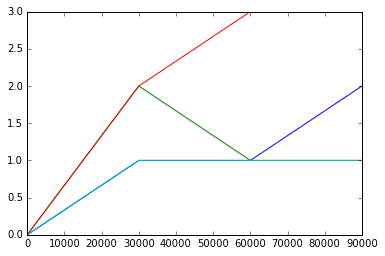

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

#here we plot a richness (number of otus) plot.
num_obs_curve = RarefactionCurveFunction(n=90001, num_reps=1, step=30000, func=number_unique_obs, axis=0)
curve_df = exp.apply(num_obs_curve).data_df

print(curve_df.columns)

for sample in curve_df:
    plt.plot(curve_df.index, curve_df[sample])

### Distance Matrix transforms

Distance Matrix transforms internally utilize the cdist function from scipy.spatial

The cdist function accepts either a string for the builtin functions already provided in scipy
(see http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.spatial.distance.cdist.html)
or it can accept a function (which accepts two arguments - calculating the distance between them).

The DistanceMatrix Transform constructor accepts the metric (string or function), as explained just above.

In [18]:
from omicexperiment.transforms.general import DistanceMatrix

rarefied_90000 = exp.rarefy(90000, num_reps=10)

rarefied_90000.apply(DistanceMatrix('braycurtis')).data_df

,1234,9876,sample1,sample2
1234,0.000000,1.000000,0.999800,0.999989
9876,1.000000,0.000000,0.999978,1.000000
sample1,0.999800,0.999978,0.000000,0.000211
sample2,0.999989,1.000000,0.000211,0.000000


You can then apply PCoA on the resulting distance matrix dataframe. Here we utilize sci-kit bio's implementation.

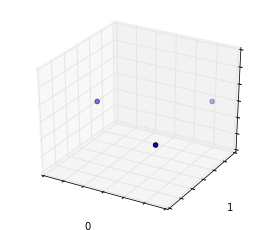

In [19]:
from skbio.stats.ordination import pcoa
pcoa_results = pcoa(rarefied_90000.apply(DistanceMatrix('braycurtis')).data_df)
pcoa_results

PCoA is also implemented in omicexperiment as a Transform. It is based on the excellent sci-kit bio's implementation, with minor changes.

In [20]:
from omicexperiment.transforms.ordination import PCoA
bray_curtis_90000 = rarefied_90000.apply(DistanceMatrix('braycurtis'))
pcoa_bray_curtis_90000 = bray_curtis_90000.apply(PCoA)
pcoa_bray_curtis_90000.data_df

,1234,9876,sample1,sample2
PC1,0.432815,0.433143,-0.432918,-0.433040
PC2,-0.500094,0.499906,0.000011,0.000178
PC3,0.000000,-0.000000,-0.000000,0.000000
PC4,-0.000000,-0.000000,-0.000000,-0.000000


PC1    0.749883
PC2    0.500000
PC3    0.000000
PC4    0.000000
dtype: float64


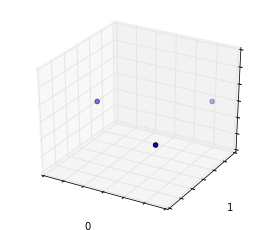

In [21]:
#the scikit-bio OrdinationResults object is stored in the experiment's metadata dict under the key 'pcoa'
print(pcoa_bray_curtis_90000.metadata['pcoa'].eigvals)
pcoa_bray_curtis_90000.metadata['pcoa']

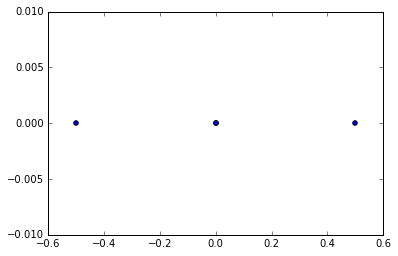

In [22]:
#Plot 2nd vs 3rd principal coordinate
from matplotlib import pyplot
pyplot.scatter(pcoa_bray_curtis_90000.data_df.loc['PC2'], pcoa_bray_curtis_90000.data_df.loc['PC3'])

# TODO
- Consider unifying filters and transforms API?